## Introducción

La empresa de telecomunicaciones Megaline busca mejorar la asignación de planes para sus clientes mediante la implementación de un modelo de machine learning que permita predecir el plan ideal para cada usuario basado en su comportamiento de uso. Este proyecto tiene como objetivo principal desarrollar un modelo de clasificación robusto para recomendar entre dos planes principales: Smart y Ultra, basándose en las características de uso de llamadas, mensajes, datos móviles y otros comportamientos mensuales.

## Objetivos del Proyecto
### Exploración y Preprocesamiento de Datos

- Analizar las características del conjunto de datos para identificar patrones, valores extremos y posibles problemas de calidad.
- Implementar técnicas de preprocesamiento como el escalado de variables numéricas, imputación de valores faltantes y detección de valores extremos.
### Entrenamiento y Evaluación de Modelos

- Dividir el conjunto de datos en entrenamiento, validación y prueba.
- Entrenar y comparar distintos modelos de clasificación, incluyendo regresión logística, árboles de decisión y bosques aleatorios, ajustando sus hiperparámetros y probando diferentes umbrales.
### Optimización de Métricas

- Maximizar la exactitud, el F1 Score y el AUC-ROC del modelo seleccionado para asegurar una clasificación precisa y equilibrada.
### Entrega de Recomendaciones

- Seleccionar el modelo más eficiente basado en las métricas de evaluación.
- Presentar los resultados y conclusiones al cliente con un enfoque en la claridad y la aplicabilidad práctica.

## Preparación y Carga de Datos

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df =pd.read_csv('datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


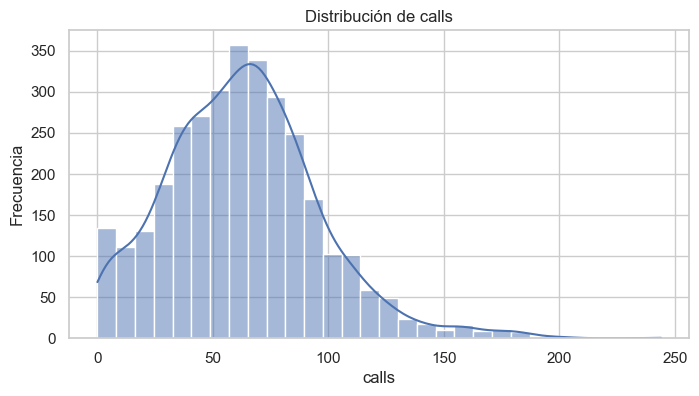

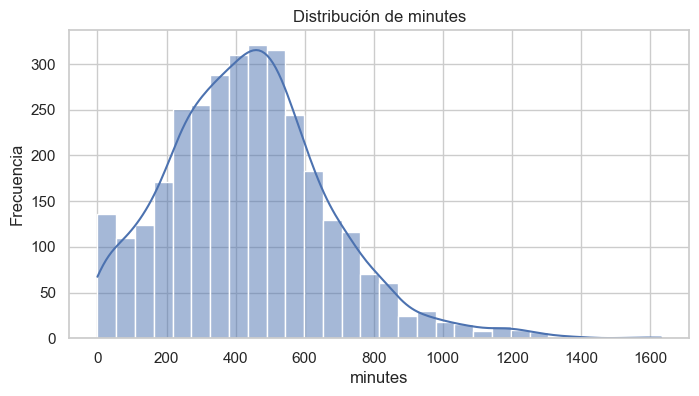

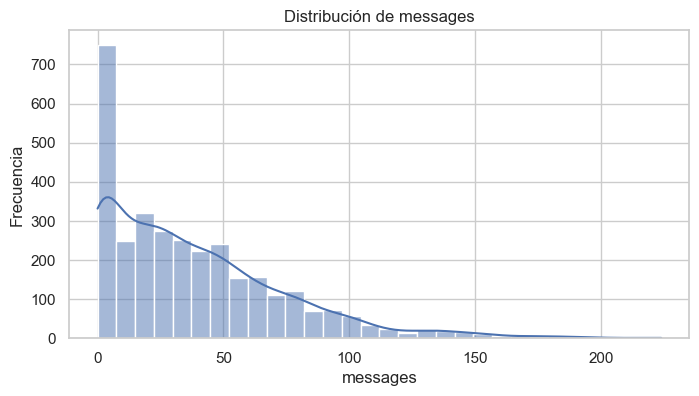

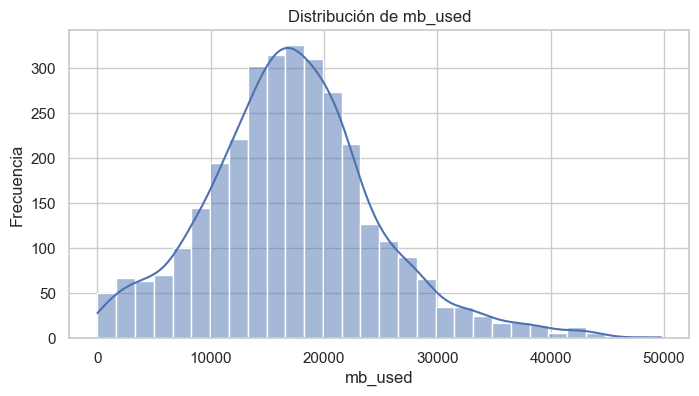

In [6]:
sns.set(style="whitegrid")
columns = ['calls', 'minutes', 'messages', 'mb_used']

# Crear histogramas para cada columna numérica
for col in columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


In [7]:
for col in columns:
    Q1 = df[col].quantile(0.25)  # Primer cuartil (25%)
    Q3 = df[col].quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartil (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Límite inferior
    upper_bound = Q3 + 1.5 * IQR  # Límite superior

    print(f"{col}: Límites [{lower_bound}, {upper_bound}]")

    # Identificar valores fuera de los límites
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Valores extremos detectados en {col}: {len(outliers)}")


calls: Límites [-23.0, 145.0]
Valores extremos detectados en calls: 62
minutes: Límites [-171.45374999999973, 1017.9562499999997]
Valores extremos detectados en minutes: 61
messages: Límites [-63.0, 129.0]
Valores extremos detectados en messages: 91
mb_used: Límites [-907.2937499999753, 34823.89624999997]
Valores extremos detectados en mb_used: 77


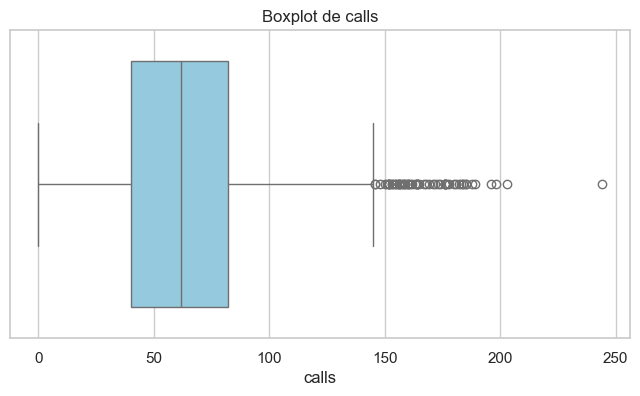

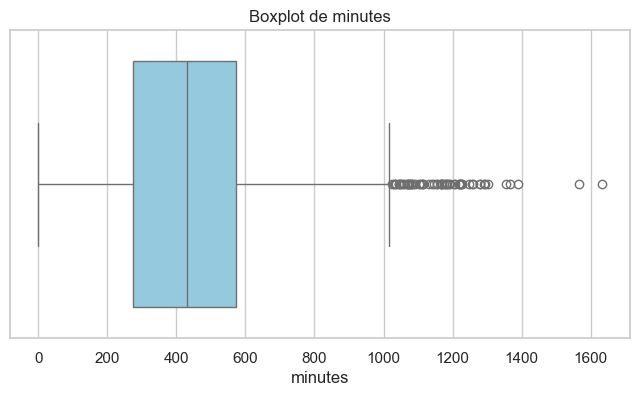

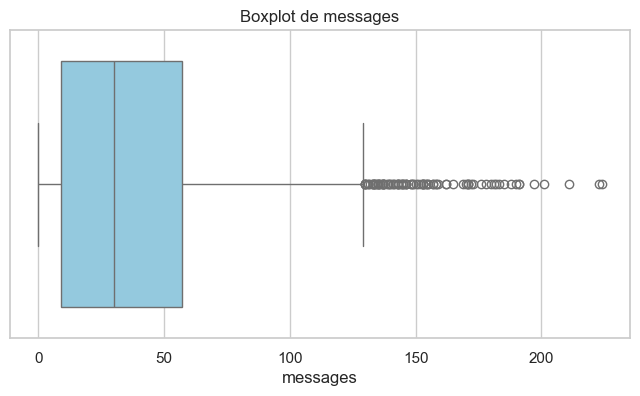

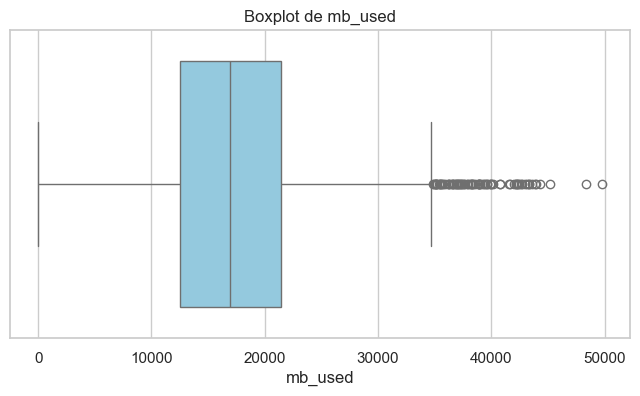

In [8]:
# Crear gráficos de caja para cada columna
for col in columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

Analizamos los valores extremos en las columnas numéricas para evaluar su impacto en el modelo. 
Si bien algunos valores se consideran extremos según los límites del gráfico, representan comportamientos válidos de los clientes, como un uso elevado de minutos o datos.
Decidimos mantenerlos porque:
  - Mejoran el rendimiento del modelo de Machine Learning.
  - Representan información relevante para diferenciar entre los planes Ultra y Smart.


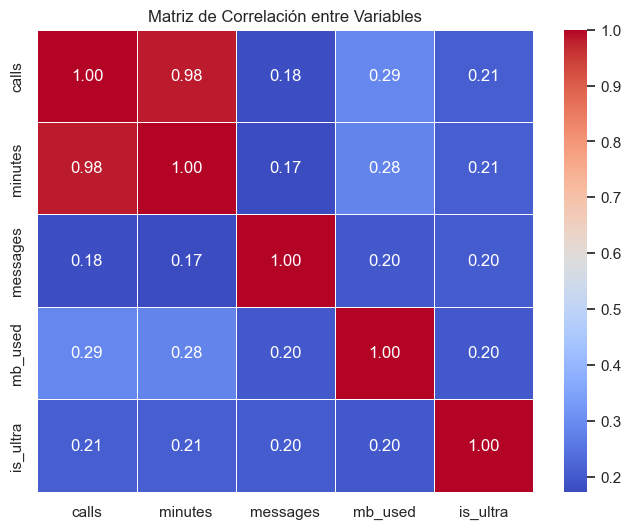

In [14]:
# Matriz de correlación
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr()

# Heatmap de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()


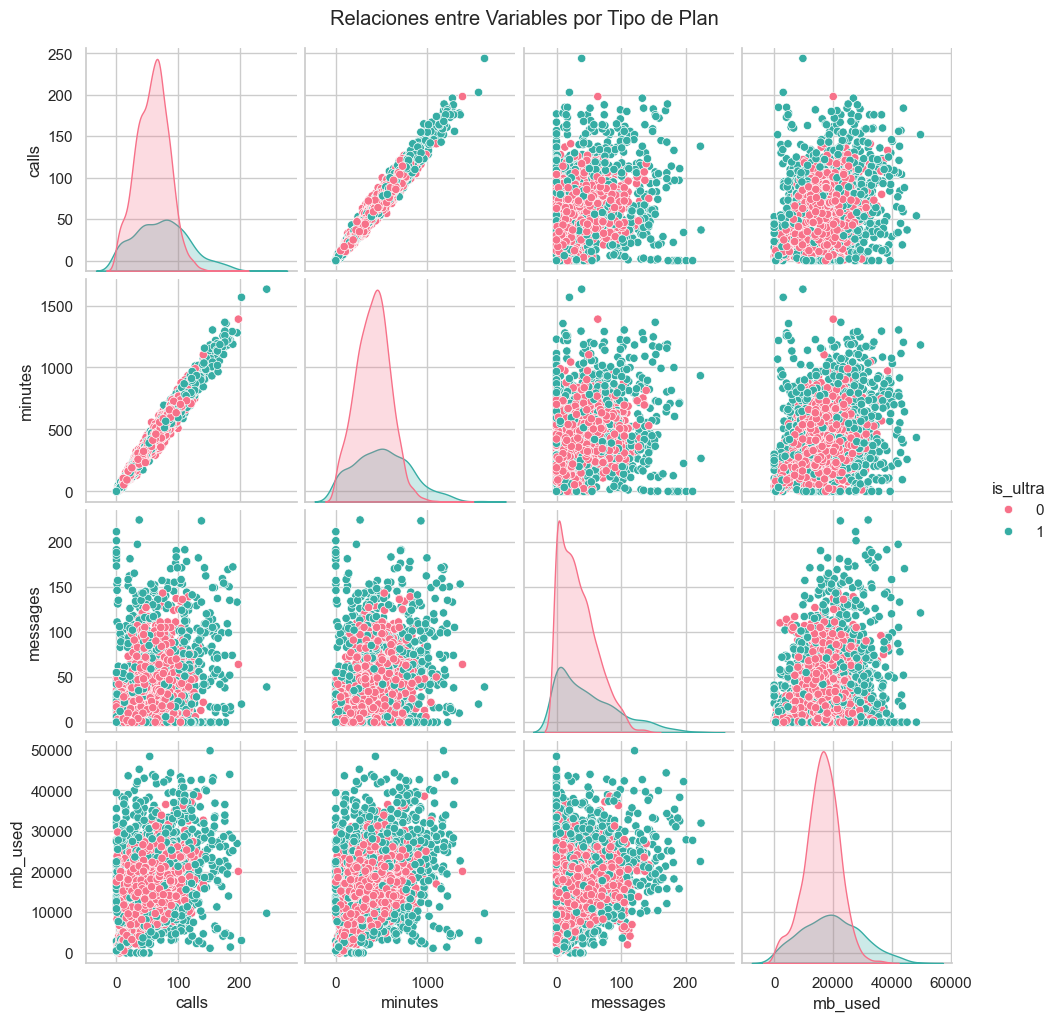

In [19]:
# Pairplot para explorar relaciones
sns.pairplot(df, vars=['calls', 'minutes', 'messages', 'mb_used'], hue='is_ultra', palette='husl')
plt.suptitle("Relaciones entre Variables por Tipo de Plan", y=1.02)
plt.show()


In [9]:
x = df.drop(columns=["is_ultra"], axis =1)
y = df["is_ultra"]

In [10]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=1234)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1234)



# Crear el escalador
scaler = StandardScaler()

# Seleccionar columnas numéricas para escalar
num_columns = ['calls', 'minutes', 'messages', 'mb_used']

# Ajustar y transformar las columnas numéricas
x_train[num_columns] = scaler.fit_transform(x_train[num_columns])
x_valid[num_columns] = scaler.transform(x_valid[num_columns])
x_test[num_columns] = scaler.transform(x_test[num_columns])

# Crear el modelo de regresión logística con balanceo
lr_model = LogisticRegression(random_state=1234, solver='liblinear', class_weight='balanced')
lr_model.fit(x_train, y_train)

# Evaluamos el conjunto de validación
y_val_pred = lr_model.predict(x_valid)
y_val_prob = lr_model.predict_proba(x_valid)[:, 1]

# Métricas para validación
accuracy_valid = accuracy_score(y_valid, y_val_pred)
auc_roc_valid = roc_auc_score(y_valid, y_val_prob)
f1_valid = f1_score(y_valid, y_val_pred)


print("\nEvaluación en el conjunto de validación:")
print(f"Exactitud: {accuracy_valid:.2f}")
print(f"AUC-ROC: {auc_roc_valid:.2f}")
print(f"F1 Score: {f1_valid:.2f}")

# Evaluamos el conjunto de prueba
y_test_pred = lr_model.predict(x_test)
y_test_prob = lr_model.predict_proba(x_test)[:, 1]

# Métricas para prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_prob)
f1_test = f1_score(y_test, y_test_pred)


print("\nEvaluación en el conjunto de prueba:")
print(f"Exactitud: {accuracy_test:.2f}")
print(f"AUC-ROC: {auc_roc_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")


Evaluación en el conjunto de validación:
Exactitud: 0.63
AUC-ROC: 0.66
F1 Score: 0.51

Evaluación en el conjunto de prueba:
Exactitud: 0.65
AUC-ROC: 0.68
F1 Score: 0.53


In [11]:
# En esta parte realizaremos los modelos de árbol de decisión y bosque aleatorio con el fin de encontrar mejores resultados



# Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=1234, class_weight='balanced',  max_depth=10)
dt_model.fit(x_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred_dt = dt_model.predict(x_valid)
y_val_prob_dt = dt_model.predict_proba(x_valid)[:, 1]

# Métricas del Árbol de Decisión (Validación)
accuracy_valid_dt = accuracy_score(y_valid, y_val_pred_dt)
auc_roc_valid_dt = roc_auc_score(y_valid, y_val_prob_dt)
f1_valid_dt = f1_score(y_valid, y_val_pred_dt)

print("\nEvaluación en el conjunto de validación (Árbol de Decisión):")
print(f"Exactitud: {accuracy_valid_dt:.2f}")
print(f"AUC-ROC: {auc_roc_valid_dt:.2f}")
print(f"F1 Score: {f1_valid_dt:.2f}")

# Bosque Aleatorio
rf_model = RandomForestClassifier(random_state=1234, class_weight='balanced', n_estimators=100, max_depth=6)
rf_model.fit(x_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred_rf = rf_model.predict(x_valid)
y_val_prob_rf = rf_model.predict_proba(x_valid)[:, 1]

# Métricas del Bosque Aleatorio (Validación)
accuracy_valid_rf = accuracy_score(y_valid, y_val_pred_rf)
auc_roc_valid_rf = roc_auc_score(y_valid, y_val_prob_rf)
f1_valid_rf = f1_score(y_valid, y_val_pred_rf)

print("\nEvaluación en el conjunto de validación (Bosque Aleatorio):")
print(f"Exactitud: {accuracy_valid_rf:.2f}")
print(f"AUC-ROC: {auc_roc_valid_rf:.2f}")
print(f"F1 Score: {f1_valid_rf:.2f}")

# Evaluación final en el conjunto de prueba (Árbol de Decisión)
y_test_pred_dt = dt_model.predict(x_test)
y_test_prob_dt = dt_model.predict_proba(x_test)[:, 1]
accuracy_test_dt = accuracy_score(y_test, y_test_pred_dt)
auc_roc_test_dt = roc_auc_score(y_test, y_test_prob_dt)
f1_test_dt = f1_score(y_test, y_test_pred_dt)

print("\nEvaluación en el conjunto de prueba (Árbol de Decisión):")
print(f"Exactitud: {accuracy_test_dt:.2f}")
print(f"AUC-ROC: {auc_roc_test_dt:.2f}")
print(f"F1 Score: {f1_test_dt:.2f}")

# Evaluación final en el conjunto de prueba (Bosque Aleatorio)
y_test_pred_rf = rf_model.predict(x_test)
y_test_prob_rf = rf_model.predict_proba(x_test)[:, 1]
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
auc_roc_test_rf = roc_auc_score(y_test, y_test_prob_rf)
f1_test_rf = f1_score(y_test, y_test_pred_rf)

print("\nEvaluación en el conjunto de prueba (Bosque Aleatorio):")
print(f"Exactitud: {accuracy_test_rf:.2f}")
print(f"AUC-ROC: {auc_roc_test_rf:.2f}")
print(f"F1 Score: {f1_test_rf:.2f}")



Evaluación en el conjunto de validación (Árbol de Decisión):
Exactitud: 0.76
AUC-ROC: 0.75
F1 Score: 0.62

Evaluación en el conjunto de validación (Bosque Aleatorio):
Exactitud: 0.83
AUC-ROC: 0.85
F1 Score: 0.71

Evaluación en el conjunto de prueba (Árbol de Decisión):
Exactitud: 0.77
AUC-ROC: 0.70
F1 Score: 0.61

Evaluación en el conjunto de prueba (Bosque Aleatorio):
Exactitud: 0.83
AUC-ROC: 0.86
F1 Score: 0.71


In [12]:
# Entrenar el modelo de árbol de decisión con ajuste de umbral
tree_model = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
tree_model.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
tree_prob_test = tree_model.predict_proba(x_test)[:, 1]

# Ajuste de umbral para el árbol de decisión
best_thresh_tree, best_acc_tree, best_f1_tree = 0, 0, 0
for t in np.arange(0, 1.01, 0.02):
    tree_pred_test = tree_prob_test >= t
    acc_tree = accuracy_score(y_test, tree_pred_test)
    f1_tree = f1_score(y_test, tree_pred_test)
    if f1_tree > best_f1_tree:
        best_thresh_tree, best_acc_tree, best_f1_tree = t, acc_tree, f1_tree

# Calcular AUC-ROC
auc_roc_tree = roc_auc_score(y_test, tree_prob_test)

print("\nÁrbol de Decisión:")
print(f"Mejor Umbral: {best_thresh_tree:.2f}")
print(f"Exactitud: {best_acc_tree:.2f}")
print(f"F1 Score: {best_f1_tree:.2f}")
print(f"AUC-ROC: {auc_roc_tree:.2f}")



Árbol de Decisión:
Mejor Umbral: 0.42
Exactitud: 0.81
F1 Score: 0.66
AUC-ROC: 0.78


In [13]:
# Entrenar el modelo de bosque aleatorio con ajuste de umbral
rf_model = RandomForestClassifier(random_state=12345, max_depth=6, class_weight='balanced')
rf_model.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
rf_prob_test = rf_model.predict_proba(x_test)[:, 1]

# Ajuste de umbral para el bosque aleatorio
best_thresh_rf, best_acc_rf, best_f1_rf = 0, 0, 0
for t in np.arange(0, 1.01, 0.02):
    rf_pred_test = rf_prob_test >= t
    acc_rf = accuracy_score(y_test, rf_pred_test)
    f1_rf = f1_score(y_test, rf_pred_test)
    if f1_rf > best_f1_rf:
        best_thresh_rf, best_acc_rf, best_f1_rf = t, acc_rf, f1_rf

# Calcular AUC-ROC
auc_roc_rf = roc_auc_score(y_test, rf_prob_test)

print("\nBosque Aleatorio:")
print(f"Mejor Umbral: {best_thresh_rf:.2f}")
print(f"Exactitud: {best_acc_rf:.2f}")
print(f"F1 Score: {best_f1_rf:.2f}")
print(f"AUC-ROC: {auc_roc_rf:.2f}")



Bosque Aleatorio:
Mejor Umbral: 0.50
Exactitud: 0.83
F1 Score: 0.71
AUC-ROC: 0.86


Se realizaron ensayos con y sin valores extremos. Los resultados indicaron que eliminar los valores extremos reducía el rendimiento del modelo. 
Por esta razón, los valores extremos se han mantenido para maximizar la calidad de las predicciones.


## Conclusiones

Tras evaluar diversos modelos de clasificación, el Bosque Aleatorio resultó ser el más efectivo para la tarea de clasificación, superando a otros modelos como la regresión logística y el árbol de decisión. A continuación, se presentan los resultados clave del modelo final:

- Mejor Umbral: 0.50

El modelo alcanza su mejor rendimiento con un umbral estándar de 0.50 para clasificar entre los planes Smart y Ultra. Este valor equilibra adecuadamente las métricas de precisión y sensibilidad.
- Exactitud: 83%

Esto indica que el modelo clasifica correctamente el plan de los clientes en el 83% de los casos. Este nivel de precisión cumple con el umbral de calidad establecido por la empresa.
- F1 Score: 0.71

El F1 Score refleja un buen balance entre la precisión (precision) y la sensibilidad (recall), demostrando que el modelo es capaz de manejar de forma equilibrada ambas métricas, incluso en casos de desbalance de clases.
- AUC-ROC: 0.86

Un AUC-ROC de 0.86 muestra que el modelo tiene un alto poder discriminatorio para distinguir entre los clientes que deberían optar por el plan Smart o Ultra. Esto refuerza la confianza en su capacidad predictiva.

## Recomendaciones

- Implementación del Modelo

Se recomienda implementar el modelo de Bosque Aleatorio como parte del sistema de recomendación de Megaline. Este modelo ayudará a asignar de forma más precisa los planes Smart y Ultra a los clientes nuevos y existentes.
- Acciones Basadas en las Predicciones

Usar las predicciones del modelo para ofrecer promociones personalizadas a los clientes que podrían beneficiarse al cambiar de plan. Esto podría reducir el abandono y aumentar la satisfacción del cliente.
- Seguimiento Continuo

Realizar evaluaciones periódicas del rendimiento del modelo y actualizarlo con datos más recientes para mantener su efectividad.
Monitorear métricas adicionales, como la tasa de adopción de los planes recomendados, para evaluar el impacto del modelo en los resultados comerciales.
- Explicación Intuitiva

Informar al equipo de ventas y atención al cliente que el modelo no solo optimiza la asignación de planes, sino que también mejora la experiencia del cliente al ajustarse a sus necesidades reales.